In [ ]:
# Import libraries
import sys

sys.path.append("..")

from src.preprocessing import get_transforms, get_datasets, get_dataloaders
from src.utils import get_spacing, get_iso_center

import torch
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

from diffdrr.drr import DRR
from diffdrr.visualization import plot_drr
from diffdrr.data import read

from diffdrr.pose import convert
from diffdrr.visualization import drr_to_mesh, img_to_mesh
import pyvista

# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
# Get transforms
transform = get_transforms(contrast_value=1000)

# Get datasets
train_ds, val_ds = get_datasets(
    root_dir="../data",
    collection="HCC-TACE-Seg",
    transform=transform,
    download_len=5,
    val_frac=0.2,
)

# Get dataloaders
train_loader, val_loader = get_dataloaders(train_ds, val_ds, batch_size=1)

# Get datalists
train_dl = train_ds.datalist
val_dl = val_ds.datalist

# Check length of datasets, dataloaders and datalists
print(train_ds.get_indices(), val_ds.get_indices())
print(len(train_loader), len(val_loader))
print(len(train_dl), len(val_dl))

In [ ]:
# Sample a batch of data from the dataloader
batch = next(iter(train_loader))

# Separate the image and segmentation from the batch
image, seg = batch["image"], batch["seg"]

print(image.shape, seg.shape)
print(image.dtype, seg.dtype)

In [ ]:
# labels = ["Liver", "Mass", "Portal vein", "Abdominal aorta", "Background"]

# structures = ["Liver", "Mass", "Portal vein", "Abdominal aorta", "Background"]
# labels = subject.structures.query(f"group in {structures}")["id"].tolist()

# Read in CT volume and label map
subject = read(tensor=image[0], label_tensor=seg[0], orientation="AP", bone_attenuation_multiplier=5)

In [ ]:
subject_path = read(
    filename=train_dl[0]["image"],
    orientation="AP",
    bone_attenuation_multiplier=3,
)

In [ ]:
print(subject_path["volume"])
print(subject["volume"])

In [ ]:
print(subject["volume"].affine)
print(subject_path["volume"].affine)

In [ ]:
# Create a DRR object
drr = DRR(
    subject,  # A torchio.Subject object storing the CT volume, origin, and voxel spacing
    sdd=1020,  # Source-to-detector distance (i.e., the C-arm's focal length)
    height=200,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    width=200,  # Width of the DRR
    delx=2.0,  # Pixel spacing (in mm)
    dely=2.0,  # Pixel spacing (in mm)
    x0=0,  # # Principal point X-offset
    y0=0,  # Principal point Y-offset
    p_subsample = None,  # Proportion of pixels to randomly subsample
    reshape = True,  # Return DRR with shape (b, 1, h, w)
    reverse_x_axis = True,  # If True, obey radiologic convention (e.g., heart on right)
    patch_size = None,  # Render patches of the DRR in series
    renderer = "siddon",  # Rendering backend, either "siddon" or "trilinear"
).to(device)

torch.Size([1, 200, 200])


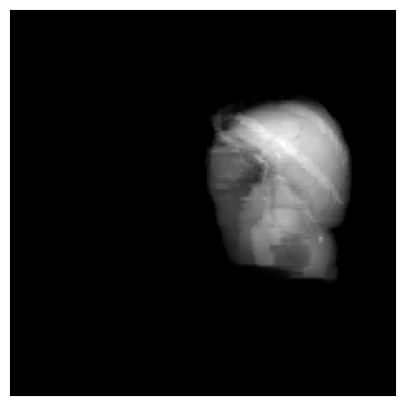

In [38]:
# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
rotations = torch.tensor([[0.0, 0.0, 0.0]], device=device)
translations = torch.tensor([[0.0, 850.0, 0.0]], device=device)
img = drr(rotations, translations, parameterization="euler_angles", convention="ZXY", mask_to_channels = True)
print(img[:, 0, :, :].shape)
plot_drr(img[:, 0, :,:].unsqueeze(dim=1), ticks=False)
plt.show()

In [ ]:
# from diffdrr.visualization import plot_mask

# # labels = ["Liver", "Mass", "Portal vein", "Abdominal aorta", "Background"]

# # Relabel classes in the TotalSegmentator dataset
# groups = {
#     "Liver": "Liver",
#     "Mass": "Mass",
#     "Portal vein": "Portal vein",
#     "Abdominal aorta": "Abdominal aorta",
#     "Background": "Background",
# }

# # Plot the segmentation masks
# fig, axs = plt.subplots(
#     nrows=2,
#     ncols=4,
#     figsize=(14, 7.75),
#     tight_layout=True,
#     dpi=300,
# )

# im = img.sum(dim=1, keepdim=True)
# plot_drr(im, axs=axs[0, 0], ticks=False, title="DRR")
# plot_drr(im, axs=axs[1, 0], ticks=False, title="All Segmentations")

# for (group, title), ax in zip(groups.items(), axs[:, 1:].flatten()):
#     jdxs = subject.mask.query(f"group == '{group}'")["id"].tolist()
#     im = img[:, jdxs]
#     plot_drr(im.sum(dim=1, keepdim=True), title=title, axs=ax, ticks=False)
#     masks = plot_mask(im, axs=ax, return_masks=True)
#     for jdx in range(masks.shape[1]):
#         axs[1, 0].imshow(masks[0, jdx], alpha=0.5)
# plt.show()